# import the libraries we need to make the model

In [26]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [27]:
import seaborn as sns

In [28]:
from sklearn.metrics import ( 
    roc_curve, 
    auc, 
    f1_score, 
    precision_recall_curve, 
    average_precision_score
)

# Set random seeds for reproducibility

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

# Directory paths

In [30]:
train_dir = "chest_xray/dataset/train"
test_dir = "chest_xray/dataset/test"
validation_dir = "chest_xray/dataset/val"

# Verify directory structure

In [31]:
def check_directory(directory):
    print(f"\nChecking directory: {directory}")
    if not os.path.exists(directory):
        print(f"ERROR: Directory does not exist: {directory}")
        return False
    
    subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    print("Subdirectories:", subdirs)
    
    for subdir in subdirs:
        full_path = os.path.join(directory, subdir)
        files = [f for f in os.listdir(full_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"{subdir}: {len(files)} image files")
    
    return True

# Check directories

In [32]:
check_directory(train_dir)
check_directory(test_dir)
check_directory(validation_dir)


Checking directory: chest_xray/dataset/train
Subdirectories: ['NORMAL', 'PNEUMONIA']
NORMAL: 1266 image files
PNEUMONIA: 3418 image files

Checking directory: chest_xray/dataset/test
Subdirectories: ['NORMAL', 'PNEUMONIA']
NORMAL: 159 image files
PNEUMONIA: 428 image files

Checking directory: chest_xray/dataset/val
Subdirectories: ['NORMAL', 'PNEUMONIA']
NORMAL: 158 image files
PNEUMONIA: 427 image files


True

# Image parameters

In [33]:
img_height = 128
img_width = 128
batch_size = 32

# Data Augmentation and Preprocessing

In [34]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [35]:
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [36]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Load datasets

In [37]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['NORMAL', 'PNEUMONIA']
)

Found 4684 images belonging to 2 classes.


In [38]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['NORMAL', 'PNEUMONIA']
)

Found 585 images belonging to 2 classes.


In [39]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['NORMAL', 'PNEUMONIA']
)

Found 587 images belonging to 2 classes.


# Printing dataset information

In [40]:
print("\nDataset Information:")
print("Class Indices:", train_generator.class_indices)
print("Total Training Samples:", train_generator.samples)
print("Total Validation Samples:", validation_generator.samples)
print("Total Test Samples:", test_generator.samples)


Dataset Information:
Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Total Training Samples: 4684
Total Validation Samples: 585
Total Test Samples: 587


# Load pre-trained Xception model

In [41]:
base_model = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_height, img_width, 3)
)

# Freeze base model layers

In [42]:
base_model.trainable = False

# Add custom classification layers

In [43]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model

In [44]:
model = Model(inputs=base_model.input, outputs=output)

# Compile the model

In [45]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [46]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add_12[0][0]    

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

# Callbacks for the model

In [47]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=0.00001
)

# Train the model

In [48]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.8196 - loss: 0.4056 - val_accuracy: 0.8769 - val_loss: 0.2954 - learning_rate: 1.0000e-04
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8847 - loss: 0.2628 - val_accuracy: 0.8684 - val_loss: 0.2980 - learning_rate: 1.0000e-04
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9010 - loss: 0.2348 - val_accuracy: 0.8650 - val_loss: 0.3091 - learning_rate: 1.0000e-04
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9122 - loss: 0.2182 - val_accuracy: 0.9009 - val_loss: 0.2284 - learning_rate: 2.0000e-05
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.9105 - loss: 0.2212 - val_accuracy: 0.8991 - val_loss: 0.2612 - learning_rate: 2.0000e-05
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9100 - loss: 0.2338 - val_accuracy: 0.9111 - val_loss: 0.2237 - learning_rate: 2.0000e-05
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - acc

# Evaluate on test set

In [49]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8939 - loss: 0.2468

Test Accuracy: 89.95%
Test Loss: 0.2334


# Visualize training history


## Accuracy plot &&Loss plot

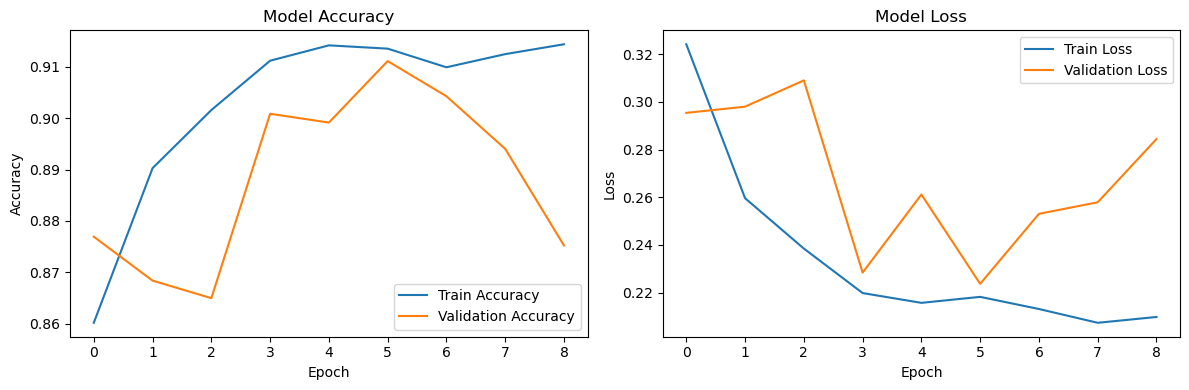

In [50]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix and Classification Report

In [51]:
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 878ms/step

Confusion Matrix:
[[ 58 101]
 [124 304]]


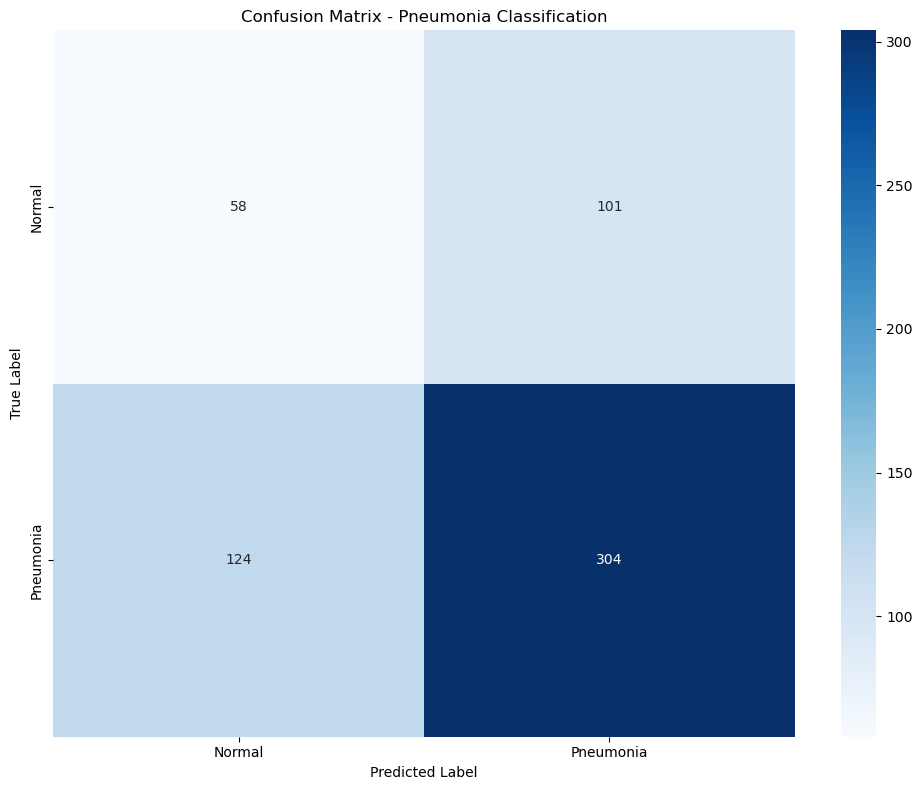

In [52]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'], 
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix - Pneumonia Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# print the classification report for the model including (precision, recall, f1-score, support)

In [53]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, 
                             target_names=['Normal', 'Pneumonia']))


Classification Report:
              precision    recall  f1-score   support

      Normal       0.32      0.36      0.34       159
   Pneumonia       0.75      0.71      0.73       428

    accuracy                           0.62       587
   macro avg       0.53      0.54      0.54       587
weighted avg       0.63      0.62      0.62       587



# ROC Curve and AUC

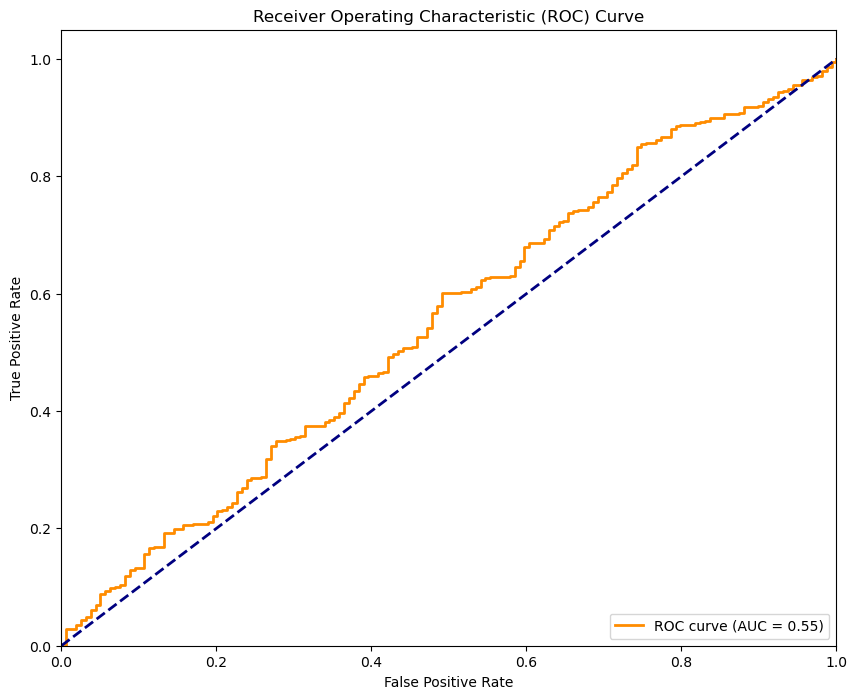

In [54]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [55]:
print(f"AUC: {roc_auc}")

AUC: 0.5506671368953153


# Precision-Recall Curve

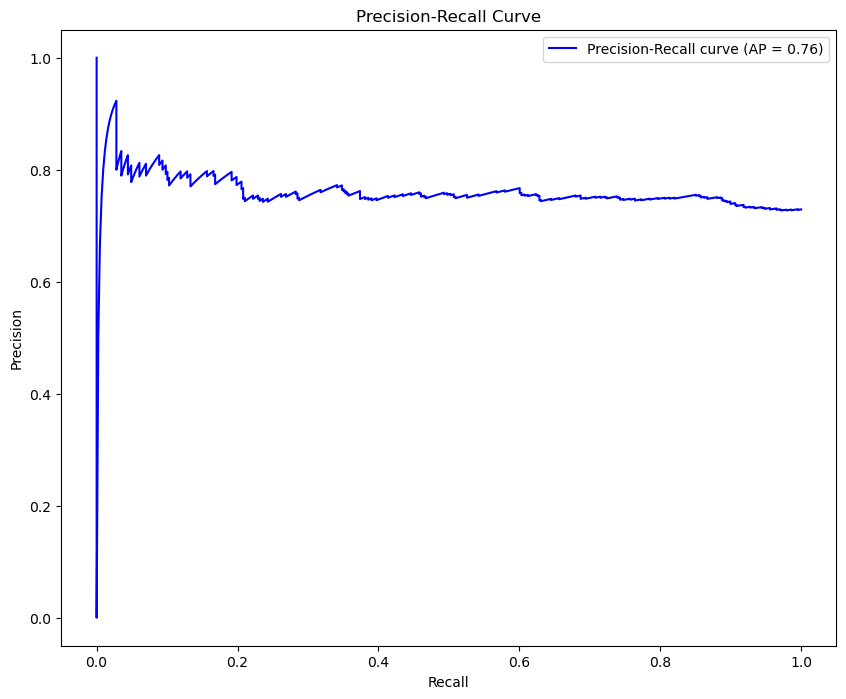

In [56]:
plt.figure(figsize=(10, 8))
precision, recall, _ = precision_recall_curve(y_true, y_pred)
avg_precision = average_precision_score(y_true, y_pred)

plt.plot(recall, precision, color='blue', 
         label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


# Binarize predictions

In [57]:
y_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_pred]

# Calculate F1 Score

In [58]:
f1 = f1_score(y_true, y_pred_binary)
print("F1-score:", f1)

F1-score: 0.7298919567827131


# Functios to make detailed metrics

In [59]:
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)

# Confusion Matrix Details

In [60]:
print("\nConfusion Matrix Details:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")


Confusion Matrix Details:
True Negatives: 58
False Positives: 101
False Negatives: 124
True Positives: 304


# Detailed metrics

In [61]:
print("\nDetailed Metrics:")
print(f"AUC Score: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")


Detailed Metrics:
AUC Score: 0.5507
Average Precision: 0.7606
Sensitivity (Recall): 0.7103
Specificity: 0.3648
F1 Score: 0.7299


# save the model

In [62]:
model.save('pneumonia_xception_model.keras')
print("\nModel saved successfully!")


Model saved successfully!


# GUI for testing the model

In [99]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model

class MedicalImageClassifierGUI:
    def __init__(self, model_path):
        self.root = tk.Tk()
        self.root.title("Medical Image Classifier")
        self.root.geometry("800x700")
        self.root.configure(bg='#110e1b')
        
        # Load pre-trained model
        self.model = load_model(model_path)
        
        # UI Components
        self.create_widgets()
        
    def create_widgets(self):
        # Image Display
        self.image_label = tk.Label(self.root, text="Select an X-Ray Image")
        self.image_label.pack(pady=10)
        
        # Select Image Button
        select_button = tk.Button(
            self.root, 
            text="Select X-Ray Image", 
            command=self.load_image
        )
        select_button.pack(pady=10)
        
        # Prediction Result Label
        self.result_label = tk.Label(
            self.root, 
            text="Prediction: None", 
            font=('Arial', 12)
        )
        self.result_label.pack(pady=10)
        
    def load_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Image files", "*.png *.jpg *.jpeg")]
        )
        
        if file_path:
            # Preprocess image
            image = self.preprocess_image(file_path)
            
            # Make prediction
            prediction = self.predict_image(image)
            
            # Display image and result
            self.display_image(file_path, prediction)
    
    def preprocess_image(self, file_path):
        image = load_img(file_path, target_size=(128, 128))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        return image
    
    def predict_image(self, image):
        prediction = self.model.predict(image)[0][0]
        return prediction
    
    def display_image(self, file_path, prediction):
        # Display image
        img = Image.open(file_path)
        img = img.resize((128, 128))
        photo = ImageTk.PhotoImage(img)
        self.image_label.config(image=photo, text='')
        self.image_label.image = photo
        
        # Display prediction
        result_text = (
            f"Pneumonia Probability: {prediction*100:.2f}%\n"
            f"{'Pneumonia Detected' if prediction > 0.5 else 'Normal'}"
        )
        self.result_label.config(text=result_text)
    
    def run(self):
        self.root.mainloop()

def main():
    gui = MedicalImageClassifierGUI('pneumonia_xception_model.keras')
    gui.run()

if __name__ == "__main__":
    main()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
